In [1]:
# Import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_data(file_id = None, file_path = None) -> pd.DataFrame:
    if file_id:
        url = f'https://drive.google.com/uc?export=download&id={file_id}'
        return pd.read_csv(url)

    if file_path:
        return pd.read_csv(file_path)

    raise ValueError('No file_id or file_path provided')

In [3]:
diabetic_data = load_data(file_path = 'diabetic_data.csv')

# Part 1: Building up a basic predictive model

In [4]:
# Show the shape of the data.
diabetic_data.shape

(101766, 50)

In [5]:
# Removing irrelevant columns from the dataset
diabetic_data_droped_irrelevant = diabetic_data.drop(columns=['encounter_id', 'payer_code', 'patient_nbr'])

# Displaying the dimensions of the updated dataset
diabetic_data_droped_irrelevant.shape

(101766, 47)

In [6]:
# Calculate the count of missing values represented as '?' before they are replaced
missing_before = diabetic_data_droped_irrelevant.isin(['?']).sum()

# Filter and display columns with more than 0 missing values before replacement
missing_before[missing_before > 0]

race                  2273
weight               98569
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

In [7]:
# Replace '?' with NA to properly identify missing values
diabetic_data_dropped_missing = diabetic_data_droped_irrelevant.replace(['?'], pd.NA)

# Calculate and display the number of NA values in each column where they exist
missing_before = diabetic_data_dropped_missing.isna().sum()
missing_before = missing_before[missing_before > 0]
missing_before

race                  2273
weight               98569
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

In [8]:
# Updating 'readmitted' column to binary values: 1 for readmitted in less than 30 days, 0 otherwise
diabetic_data_dropped_missing['readmitted'] = diabetic_data_dropped_missing['readmitted'].replace({
    '<30': 1,
    '>30': 0,
    'NO': 0,
})

# Displaying the distribution of binary values in 'readmitted' after conversion
readmitted_value_counts = diabetic_data_dropped_missing['readmitted'].value_counts(
)
readmitted_value_counts

0    90409
1    11357
Name: readmitted, dtype: int64

In [9]:
# Grouping column names by their data types
grouped_columns = diabetic_data_dropped_missing.columns.to_series().groupby(diabetic_data_dropped_missing.dtypes).groups

# Converting the dictionary's keys from dtype objects to their string representation
grouped_columns = {k.name: v.tolist() for k, v in grouped_columns.items()}

grouped_columns

{'int64': ['admission_type_id',
  'discharge_disposition_id',
  'admission_source_id',
  'time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'number_diagnoses',
  'readmitted'],
 'object': ['race',
  'gender',
  'age',
  'weight',
  'medical_specialty',
  'diag_1',
  'diag_2',
  'diag_3',
  'max_glu_serum',
  'A1Cresult',
  'metformin',
  'repaglinide',
  'nateglinide',
  'chlorpropamide',
  'glimepiride',
  'acetohexamide',
  'glipizide',
  'glyburide',
  'tolbutamide',
  'pioglitazone',
  'rosiglitazone',
  'acarbose',
  'miglitol',
  'troglitazone',
  'tolazamide',
  'examide',
  'citoglipton',
  'insulin',
  'glyburide-metformin',
  'glipizide-metformin',
  'glimepiride-pioglitazone',
  'metformin-rosiglitazone',
  'metformin-pioglitazone',
  'change',
  'diabetesMed']}

In [10]:
# Determining the percentage of missing values in each column
missing_percentage = (diabetic_data_dropped_missing.isna().sum() / len(diabetic_data_dropped_missing)) * 100

# Identifying columns with over 90% missing values for potential removal
columns_to_drop = missing_percentage[missing_percentage > 90].index
columns_to_drop

Index(['weight'], dtype='object')

In [11]:
# Removing columns from the dataset that have more than 90% missing values
diabetic_data_reduced = diabetic_data_dropped_missing.drop(columns=columns_to_drop)

# Calculating and displaying the new percentages of missing values in each column after removal
new_missing_percentage = (diabetic_data_reduced.isna().sum() / len(diabetic_data_reduced)) * 100
new_missing_percentage[new_missing_percentage > 0]

race                  2.233555
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

In [12]:
# List of columns with near zero variance
near_zero_variance_columns = [
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

# Delete the specified near zero-variance columns
diabetic_data_dropped_zero_variance = diabetic_data_reduced.drop(columns=near_zero_variance_columns)

# Show the new shape of the data to confirm the deletion
diabetic_data_dropped_zero_variance.shape

(101766, 29)

In [13]:
# Specifying IDs associated with unclear or irrelevant information for filtering out
admission_type_ids = [5, 6, 8]  # Categories like 'Not Available', 'NULL', 'Not Mapped'
discharge_disposition_ids = [18, 25, 26]  # Categories like 'Expired', 'NULL', 'Not Mapped', 'Unknown/Invalid'
admission_source_ids = [9, 15, 17, 20, 21]  # Categories like 'Not Available', 'NULL', 'Not Mapped', 'Unknown/Invalid'

# Calculating the total number of rows that meet the criteria for removal based on above IDs
diabetic_data_dropped_zero_variance[
    (diabetic_data_dropped_zero_variance['admission_type_id'].isin(admission_type_ids)) |
    (diabetic_data_dropped_zero_variance['discharge_disposition_id'].isin(discharge_disposition_ids)) |
    (diabetic_data_dropped_zero_variance['admission_source_id'].isin(admission_source_ids))
].shape[0]

15256

In [14]:
# Filtering out rows based on specified IDs that indicate unclear or irrelevant information
diabetic_data_filtered_ids = diabetic_data_dropped_zero_variance[
    ~diabetic_data_dropped_zero_variance['admission_type_id'].isin(admission_type_ids) &
    ~diabetic_data_dropped_zero_variance['discharge_disposition_id'].isin(discharge_disposition_ids) &
    ~diabetic_data_dropped_zero_variance['admission_source_id'].isin(admission_source_ids)
].copy()

# Displaying the dimensions of the dataset after filtering
diabetic_data_filtered_ids.shape

(86510, 29)

In [15]:
# Filtering out rows where 'gender' is 'Unknown/Invalid'
diabetic_data_filtered_ids = diabetic_data_filtered_ids[diabetic_data_filtered_ids['gender'] != 'Unknown/Invalid']

# Removing rows where 'race' is categorized as 'Other'
diabetic_data_filtered_ids = diabetic_data_filtered_ids[diabetic_data_filtered_ids['race'] != 'Other']

# Replacing missing values in 'medical_specialty' with 'Unknown'
diabetic_data_filtered_ids['medical_specialty'] = diabetic_data_filtered_ids['medical_specialty'].fillna('Unknown')

# Dropping all rows that still contain null values after the above replacements
diabetic_data_filled = diabetic_data_filtered_ids.dropna()

# Displaying the dimensions of the cleaned dataset to confirm the deletion of rows
diabetic_data_filled.shape

(81987, 29)

In [16]:
# Calculate the number of missing values in each column after dropping near zero variance columns
missing_after = diabetic_data_filled.isna().sum()

# Identify and list columns that still contain missing values
missing_after[missing_after > 0]

Series([], dtype: int64)

In [17]:
# Copying the filtered dataset for normalization
normalized_diabetic_data = diabetic_data_filled.copy()

# Normalizing medication-related features by encoding their levels numerically
for col in ["metformin", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", "insulin"]:
    normalized_diabetic_data[col] = normalized_diabetic_data[col].apply(
      lambda x : 10 if x == 'Up' else ( -10 if x == 'Down' else ( 0 if x == 'Steady' else  -20))
    )

# Normalizing A1C result measurements
normalized_diabetic_data['A1Cresult'] = normalized_diabetic_data['A1Cresult'].apply(
  lambda x : 7 if x == '>7' else (8 if  x == '>8' else ( 5 if x == 'Norm' else  0))
)

# Encoding 'change' as binary
normalized_diabetic_data['change'] = normalized_diabetic_data['change'].apply(
  lambda x : 1 if x == 'Ch' else -1
)

# Encoding 'diabetesMed' as binary
normalized_diabetic_data['diabetesMed'] = normalized_diabetic_data['diabetesMed'].apply(
  lambda x : -1 if x == 'No' else 1
)

# Normalizing maximum glucose serum test results
normalized_diabetic_data['max_glu_serum'] = normalized_diabetic_data['max_glu_serum'].apply(
  lambda x : 200 if x == '>200' else ( 300 if x == '>300' else ( 100 if x == 'Norm' else  0))
)

# Normalizing 'age' column to represent the midpoint of each age range
normalized_diabetic_data['age'] = normalized_diabetic_data['age'].apply(
    lambda x: np.mean([int(age) for age in x.strip('[)').split('-')])
)

# Function to categorize ICD diagnosis codes into broader categories
def categorize_diagnosis(diag_code):
    """
    Categorize the ICD diagnosis codes into broader categories.
    """
    try:
        if pd.isnull(diag_code):
            return None
        code = str(diag_code)
        if code.startswith('E') or code.startswith('V') or code[0].isdigit():
            code_value = float(code.split('V')[0].split('E')[0])  # Remove letter prefixes for numeric comparison
            if 1 <= code_value <= 139:
                return 1 # 'Infectious and Parasitic Diseases'
            elif 140 <= code_value <= 239:
                return 2 # 'Neoplasms'
            elif 240 <= code_value <= 279:
                return 3 # 'Endocrine, Nutritional, and Metabolic Diseases'
            elif 280 <= code_value <= 289:
                return 4 # 'Diseases of the Blood and Blood-forming Organs'
            elif 290 <= code_value <= 319:
                return 5 # 'Mental Disorders'
            elif 320 <= code_value <= 389:
                return 6 # 'Diseases of the Nervous System'
            elif 390 <= code_value <= 459 or code == '785':
                return 7 # 'Diseases of the Circulatory System'
            elif 460 <= code_value <= 519 or code == '786':
                return 8 # 'Diseases of the Respiratory System'
            elif 520 <= code_value <= 579 or code == '787':
                return 9 # 'Diseases of the Digestive System'
            elif 580 <= code_value <= 629 or code == '788':
                return 10 # 'Diseases of the Genitourinary System'
            elif 630 <= code_value <= 679:
                return 11 # 'Pregnancy, Childbirth, and the Puerperium'
            elif 680 <= code_value <= 709 or code.startswith('V'):
                return 12 # 'Skin and Subcutaneous Tissue Diseases'
            elif 710 <= code_value <= 739:
                return 13 # 'Musculoskeletal System and Connective Tissue Diseases'
            elif 740 <= code_value <= 759:
                return 14 # 'Congenital Anomalies'
            elif 760 <= code_value <= 779:
                return 15 # 'Certain Conditions Originating in the Perinatal Period'
            elif 780 <= code_value <= 799 or code.startswith('E'):
                return 16 # 'Symptoms, Signs, and Ill-defined Conditions'
            elif 800 <= code_value <= 999:
                return 17 # 'Injury and Poisoning'
            else:
                return None
        else:
            return None
    except ValueError:
        return None

# Applying diagnosis categories to diagnosis columns
for col in ['diag_1', 'diag_2', 'diag_3']:
    normalized_diabetic_data[col + '_category'] = normalized_diabetic_data[col].apply(categorize_diagnosis)

# Removing original diagnosis columns after categorization
normalized_diabetic_data = normalized_diabetic_data.drop(columns=['diag_1', 'diag_2', 'diag_3'])

# Removing original diagnosis columns after categorization
normalized_diabetic_data.dropna(inplace=True)


# Displaying the new shape of the data
normalized_diabetic_data.shape

(75080, 29)

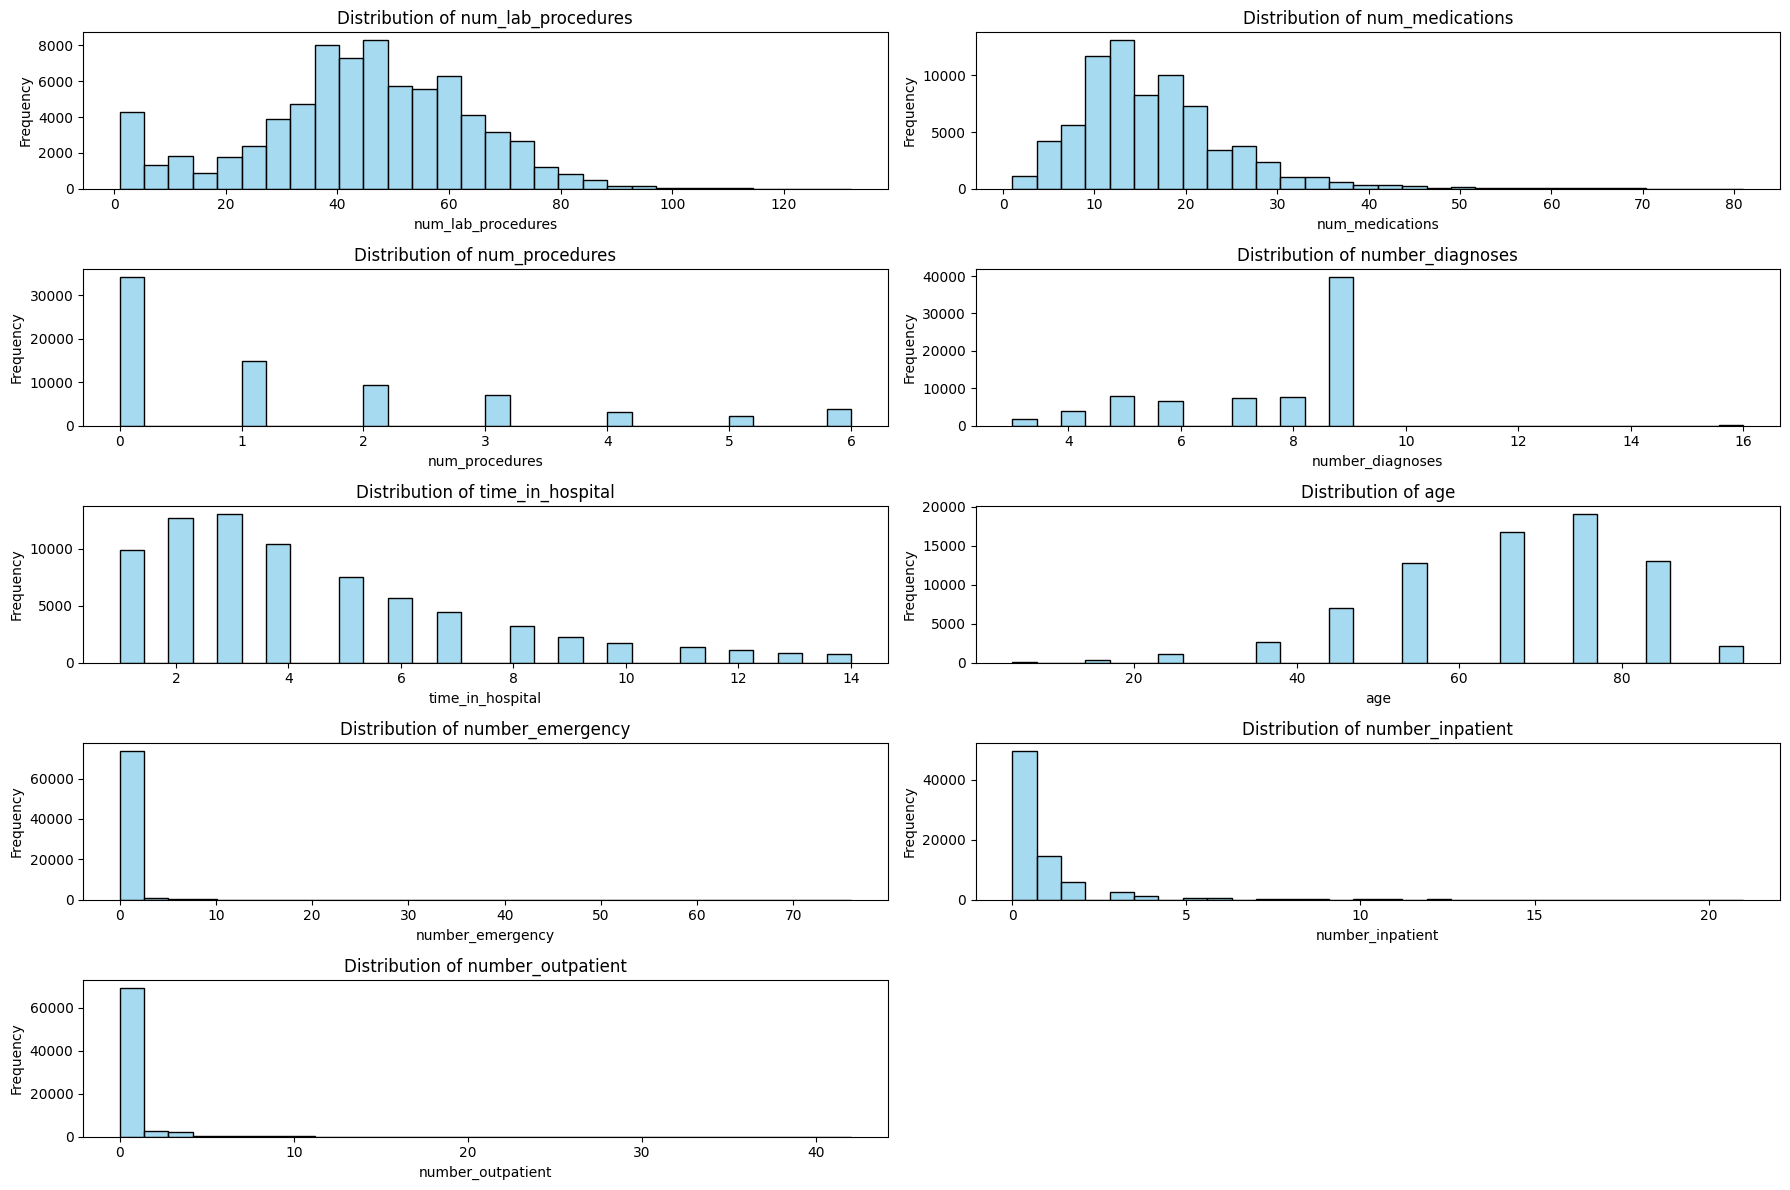

In [18]:

# Defining the columns where outliers are to be examined
outlier_columns = [
    'num_lab_procedures',  # Subject to z-score analysis
    'num_medications',     # Subject to z-score analysis
    'num_procedures',      # Subject to IQR method
    'number_diagnoses',    # Subject to IQR method
    'time_in_hospital',    # Subject to IQR method
    'age',                 # Subject to IQR method
    'number_emergency',
    'number_inpatient',
    'number_outpatient',
]

# Summary of outlier analysis methods based on the distribution of each column
# 'iqr': Column outliers determined by Interquartile Range method
# 'z-score': Column outliers identified by Z-score method
# 'percentile': Column outliers assessed by percentile thresholds

# Outlier analysis summary:
# column                        iqr     z-score  percentile
# num_lab_procedures            217     [51]     2233
# num_medications               3396    [1539]   3725
# num_procedures                [4940]  4940     0
# number_diagnoses              [62]    78       115
# number_emergency              11286   1648     [1648]
# number_inpatient              6988    3606     [1994]
# number_outpatient             16612   2543     [1449]
# time_in_hospital              [2246]  2246     2246

# Setting the size of the plot for better readability and visualization
plt.figure(figsize=(18, 12))

# Iterating through each column to create histograms
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(5, 2, i)  # Arranging the charts in a grid of 5 rows by 2 columns
    sns.histplot(normalized_diabetic_data[column], color='skyblue', bins=30)  # Using seaborn for histogram
    plt.title(f'Distribution of {column}')  # Title for each histogram
    plt.ylabel('Frequency')  # Y-axis label
    plt.xlabel(column)  # X-axis label

# Adjusting the layout for clearer presentation
plt.tight_layout()

plt.show()

In [19]:
# Create a copy of the normalized dataset for outlier removal
non_outlier_diabetic_data = normalized_diabetic_data.copy()

# Columns to remove outliers using Interquartile Range (IQR)
outlier_columns_iqr = [
  'num_procedures',  # Using IQR for outlier detection
  'number_diagnoses',  # Using IQR for outlier detection
  'time_in_hospital',  # Using IQR for outlier detection
  'age',  # Using IQR for outlier detection
]

# Define IQR parameters for filtering
q_range = 0.25  # Quartile range
iqr_range = 1.5  # Multiplier for IQR

# Remove outliers based on IQR for specified columns
for column in outlier_columns_iqr:
    Q1 = normalized_diabetic_data[column].quantile(q_range)
    Q3 = normalized_diabetic_data[column].quantile(1 - q_range)
    IQR = Q3 - Q1
    non_outlier_diabetic_data = non_outlier_diabetic_data[
        (non_outlier_diabetic_data[column] >= (Q1 - iqr_range * IQR)) &
        (non_outlier_diabetic_data[column] <= (Q3 + iqr_range * IQR))
    ]

# Columns to remove outliers using Z-score
outlier_columns_zscore = [
  'num_lab_procedures',  # Using Z-score for outlier detection
  'num_medications',  # Using Z-score for outlier detection
]

# Remove outliers based on Z-score for specified columns
for column in outlier_columns_zscore:
  lower_range = round(normalized_diabetic_data[column].mean() - 3 * normalized_diabetic_data[column].std())
  upper_range = round(normalized_diabetic_data[column].mean() + 3 * normalized_diabetic_data[column].std())
  non_outlier_diabetic_data = non_outlier_diabetic_data[
      (non_outlier_diabetic_data[column] >= lower_range) &
      (non_outlier_diabetic_data[column] <= upper_range)
  ]

# Columns to remove outliers using percentile method
outlier_columns_percentile = [
  'number_emergency',  # Using percentile for outlier detection
  'number_inpatient',  # Using percentile for outlier detection
  'number_outpatient',  # Using percentile for outlier detection
]

# Define percentile range for filtering
percentile_range = 0.05  # Percentile range for outlier cutoff

# Remove outliers based on percentiles for specified columns
for column in outlier_columns_percentile:
  lower_range1 = normalized_diabetic_data[column].quantile(percentile_range)
  upper_range1 = normalized_diabetic_data[column].quantile(1 - percentile_range)
  non_outlier_diabetic_data = non_outlier_diabetic_data[
      (non_outlier_diabetic_data[column] >= lower_range1) &
      (non_outlier_diabetic_data[column] <= upper_range1)
  ]

# Display the shape of the data after removing outliers
non_outlier_diabetic_data.shape

(61686, 29)

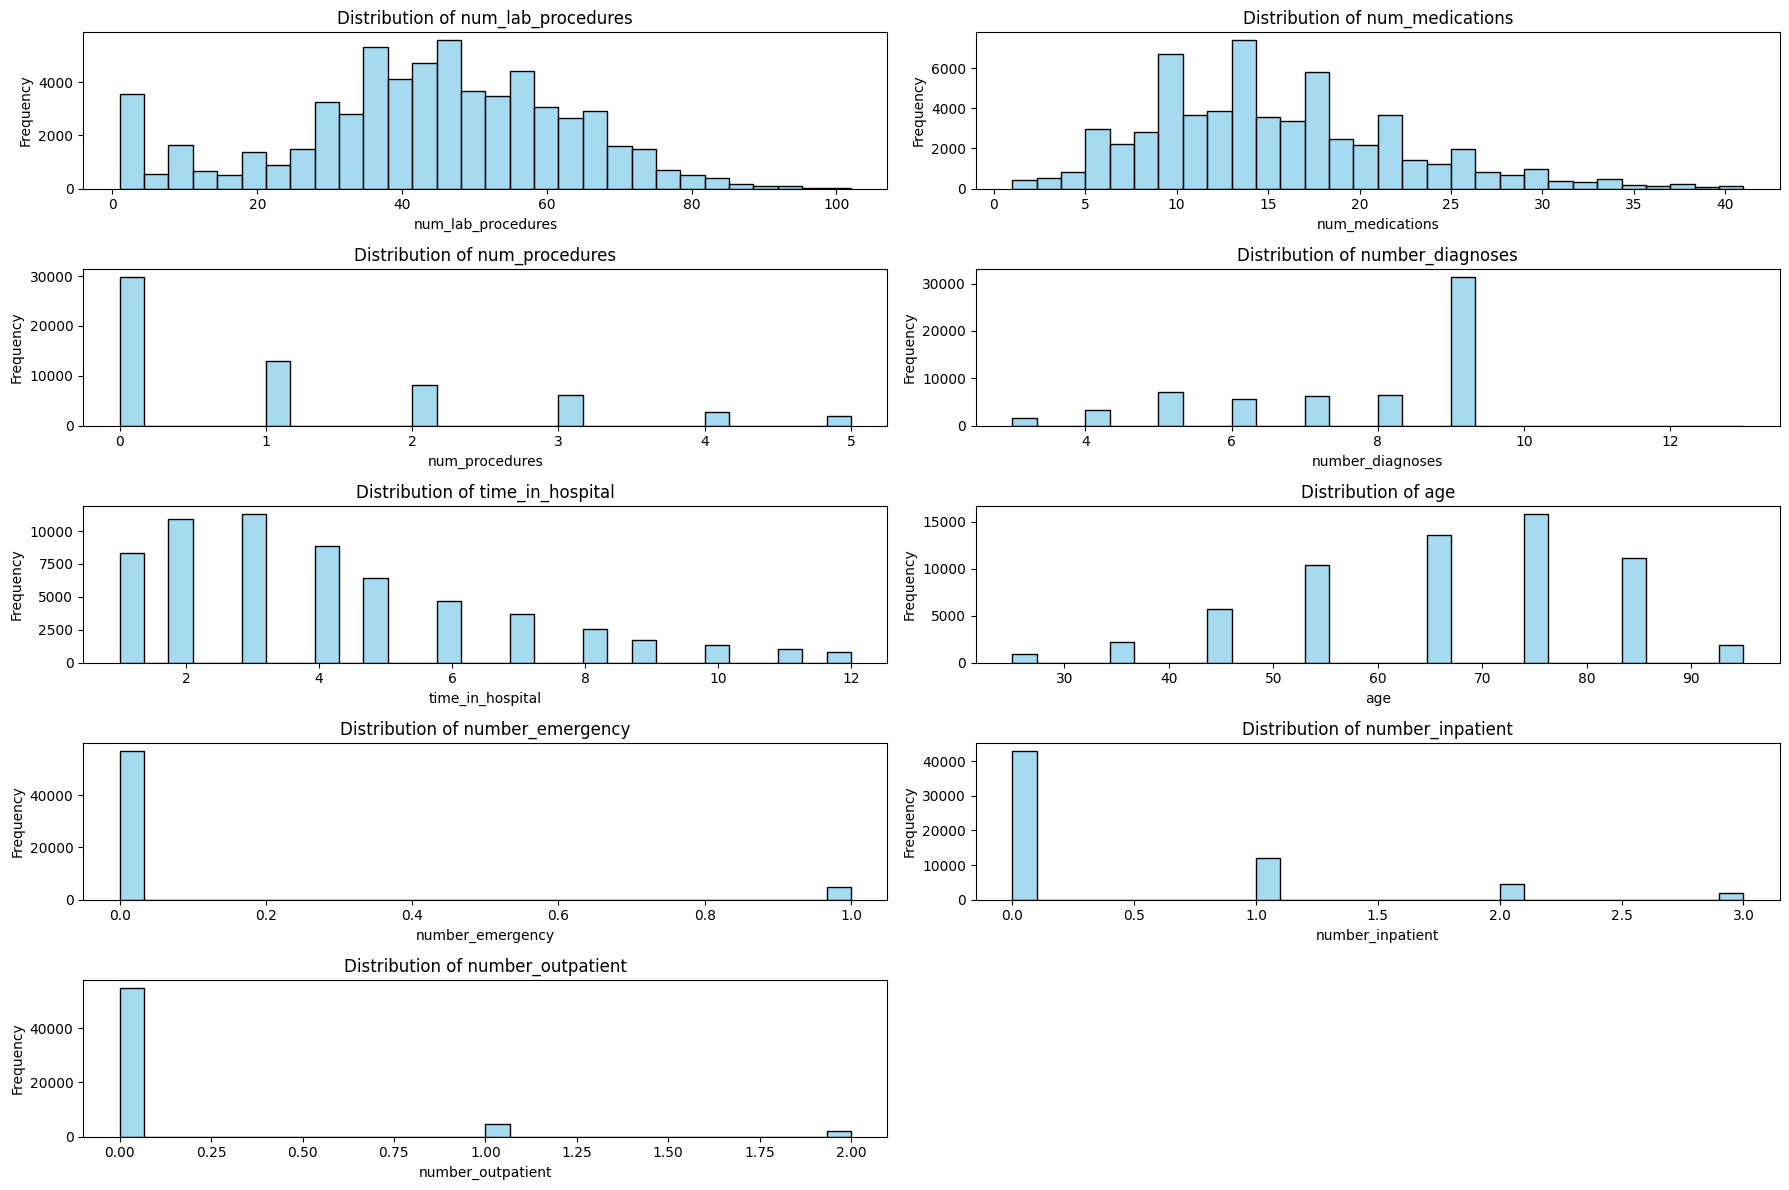

In [20]:
# Adjusting figure size for enhanced readability of the histograms
plt.figure(figsize=(18, 12))

# Iteratively generating histograms for each specified column to analyze distributions
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(5, 2, i)  # Organizing charts in a grid of 5 rows and 2 columns
    sns.histplot(non_outlier_diabetic_data[column], color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')  # Setting the title to reflect the current column
    plt.ylabel('Frequency')  # Label for the y-axis
    plt.xlabel(column)  # Label for the x-axis

# Enhancing layout spacing to prevent overlap and improve readability
plt.tight_layout()
plt.show()  # Displaying the generated histograms


In [21]:
for col in non_outlier_diabetic_data.columns:
    # Check if the column has less than ten unique value
    if len(non_outlier_diabetic_data[col].unique()) < 10:
        print(f"{col}: {non_outlier_diabetic_data[col].unique()}")

race: ['Caucasian' 'AfricanAmerican' 'Asian' 'Hispanic']
gender: ['Male' 'Female']
age: [35. 45. 75. 95. 65. 85. 55. 25.]
admission_type_id: [1 3 2 4 7]
num_procedures: [1 0 3 2 5 4]
number_outpatient: [0 1 2]
number_emergency: [0 1]
number_inpatient: [0 2 1 3]
max_glu_serum: [  0 300 100 200]
A1Cresult: [0 7 5 8]
metformin: [-20   0  10 -10]
glipizide: [-20   0 -10  10]
glyburide: [-20   0  10 -10]
pioglitazone: [-20   0  10 -10]
rosiglitazone: [-20   0  10 -10]
insulin: [ 10   0 -20 -10]
change: [ 1 -1]
diabetesMed: [ 1 -1]
readmitted: [0 1]


In [22]:
# Initialize a MinMaxScaler to scale the numerical data to a range [0, 1] for better comparison
scaler = MinMaxScaler()

# Identifying numerical columns in the dataset
numerical_columns = non_outlier_diabetic_data.select_dtypes(include=[np.number]).columns

# Optional: Scale the numerical columns for better visualization. Uncomment if scaling is desired.
non_outlier_diabetic_data[numerical_columns] = scaler.fit_transform(non_outlier_diabetic_data[numerical_columns])

# Generating a scatter matrix for all numerical columns to visualize relationships
# sns.pairplot(non_outlier_diabetic_data[numerical_columns])
# plt.suptitle('Scatter Matrix of Numerical Columns', size=16)  # Adjust title size as needed
# plt.show()

In [23]:
non_outlier_diabetic_data.corr()

C:\Users\msshi\AppData\Local\Temp\ipykernel_18324\1588064794.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  non_outlier_diabetic_data.corr()


,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,diag_1_category,diag_2_category,diag_3_category
age,1.000000,-0.040507,0.168712,0.064733,0.104374,0.036699,-0.061042,0.021676,0.027317,-0.015673,...,0.057594,0.000528,-0.009014,-0.049805,-0.037452,-0.018865,0.032914,0.026103,0.050776,0.042743
admission_type_id,-0.040507,1.000000,-0.000502,-0.776232,-0.031022,-0.271362,0.242114,0.117218,-0.005914,-0.021936,...,-0.000069,0.024020,0.035037,-0.031467,0.031019,0.011553,-0.012188,0.053856,0.020328,0.002043
discharge_disposition_id,0.168712,-0.000502,1.000000,0.007771,0.171736,0.046723,0.004345,0.140324,0.021028,0.005957,...,-0.000147,0.003917,-0.004901,0.021879,0.022958,0.002973,0.079333,0.056272,0.031800,0.045116
admission_source_id,0.064733,-0.776232,0.007771,1.000000,0.025121,0.240633,-0.220824,-0.107002,-0.026186,0.053763,...,-0.009235,-0.016949,-0.033507,0.042547,0.011283,0.004642,0.007994,-0.025250,-0.008114,0.005445
time_in_hospital,0.104374,-0.031022,0.171736,0.025121,1.000000,0.317881,0.163134,0.439368,-0.007020,0.007459,...,0.017493,0.005994,0.004237,0.103329,0.098725,0.057608,0.050752,-0.041891,0.061632,0.067515
num_lab_procedures,0.036699,-0.271362,0.046723,0.240633,0.317881,1.000000,-0.007117,0.241750,0.004584,0.025242,...,0.004532,-0.018129,-0.010337,0.093007,0.070738,0.037736,0.018952,-0.077788,0.006609,0.020529
num_procedures,-0.061042,0.242114,0.004345,-0.220824,0.163134,-0.007117,1.000000,0.289283,-0.014701,-0.020388,...,-0.002436,0.007187,0.010722,-0.006266,-0.018762,-0.020287,-0.004676,0.036854,0.054806,0.037687
num_medications,0.021676,0.117218,0.140324,-0.107002,0.439368,0.241750,0.289283,1.000000,0.054288,0.034537,...,0.032319,0.073983,0.054254,0.189439,0.247699,0.197130,0.042340,0.047083,0.067307,0.056334
number_outpatient,0.027317,-0.005914,0.021028,-0.026186,-0.007020,0.004584,-0.014701,0.054288,1.000000,0.102735,...,0.003764,0.019725,0.007628,-0.013246,0.015606,0.007049,0.020006,0.005486,0.017686,0.018182
number_emergency,-0.015673,-0.021936,0.005957,0.053763,0.007459,0.025242,-0.020388,0.034537,0.102735,1.000000,...,-0.019115,0.017278,0.010648,0.030093,0.034996,0.026423,0.026938,-0.003531,0.012156,0.017806


In [24]:
# Load the cleaned diabetic dataset from the specified CSV file
data = non_outlier_diabetic_data.copy()

# Display the distribution of the 'readmitted' column to understand the frequency of each class
distribution = data['readmitted'].value_counts()
distribution

0.0    55293
1.0     6393
Name: readmitted, dtype: int64

In [25]:
# Select specific categorical columns for visualization to understand their impact on readmission
columns_to_plot = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'medical_specialty', 'diag_1_category',
    'diag_2_category', 'diag_3_category', 'diabetesMed'
]

# Set up the plotting environment: one subplot per categorical column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 5 * len(columns_to_plot)))

# Iterate through the list of columns to create bar plots
for i, col in enumerate(columns_to_plot):
    # Calculate the distribution of 'readmitted' status for each category within the column
    counts = normalized_diabetic_data.groupby([col, 'readmitted']).size().unstack(fill_value=0)
    # Create a bar plot for each category's readmitted status
    counts.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    # Set the title and labels for each subplot for clarity
    axes[i].set_title(f'Readmitted status distribution in {col}')
    axes[i].set_ylabel('Counts')
    axes[i].set_xlabel(col)

# Ensure there is no layout overlap and display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Define columns for which we want to plot the percentage distribution of readmitted status
columns_to_plot = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'medical_specialty', 'diag_1_category',
    'diag_2_category', 'diag_3_category', 'diabetesMed'
]

# Set up the figure for plotting, with individual subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 5 * len(columns_to_plot)))

# Iteratively generate bar plots to show percentage distributions for each categorical feature
for i, col in enumerate(columns_to_plot):
    # Group the data by the column and 'readmitted' status, then count occurrences
    counts = non_outlier_diabetic_data.groupby([col, 'readmitted']).size().unstack(fill_value=0)
    # Convert the counts to percentages for a clearer comparison between categories
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    # Plot the percentages as a bar graph on the respective subplot
    percentages.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    # Set the title, y-label, and x-label for each subplot for clarity
    axes[i].set_title(f'Percentage of Readmitted Status in {col}')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(col)

# Ensure the layout is adjusted to prevent overlap and improve readability
plt.tight_layout()
plt.show()

In [ ]:
# Plot the distribution
plt.figure(figsize=[8,6])
distribution.plot(kind='bar')
plt.title('Distribution of Readmission')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)  # Assuming 0: 'No', 1: 'Yes' for readmission
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Grouping the data by 'age' and 'readmitted' columns and counting the number of occurrences for each combination
age_readmitted_counts = data.groupby(['age', 'readmitted']).size().reset_index(name='count')

# Transforming the grouped data into a pivot table for easier plotting, with ages as rows and readmission status as columns
age_readmitted_pivot = age_readmitted_counts.pivot(index='age', columns='readmitted', values='count').fillna(0)

# Creating a stacked bar plot to visualize the count of readmissions for each age group
age_readmitted_pivot.plot(kind='bar', figsize=[14,8], alpha=0.75, stacked=True)
plt.title('Count of Readmissions by Age Group')  # Set the title for the plot
plt.xlabel('Age Group')  # Set the label for the x-axis
plt.ylabel('Count of Cases')  # Set the label for the y-axis
plt.legend(title='Readmitted', labels=['No', 'Yes'])  # Customize the legend, assuming '0' represents 'No' and '1' represents 'Yes'
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better readability
plt.show()  # Display the plot


In [ ]:
# Aggregate data by the number of medications and count occurrences of each readmitted status within these groups
medications_readmission_count = data.groupby('num_medications')['readmitted'].value_counts().unstack(fill_value=0)

# Create a bar plot to visualize the relationship between the number of medications and readmission counts
medications_readmission_count.plot(kind='bar', figsize=[14,8], width=1.0, alpha=0.75)
plt.title('Count of Target Variable against Number of Medications')  # Setting the plot title
plt.xlabel('Number of Medications')  # Labeling the x-axis
plt.ylabel('Count of Cases')  # Labeling the y-axis
plt.legend(title='Readmitted', labels=['No', 'Yes'])  # Customizing the legend
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding a grid for better readability
plt.show()  # Displaying the plot

In [ ]:
# Compute the correlation matrix for the dataset
correlation_matrix = data.corr()

# Generate a mask to only show the lower triangle of the matrix, as it's mirrored across the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialize the plot figure with specified figure size
plt.figure(figsize=(18, 15))

# Plotting the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()  # Display the heatmap

* Distribution of Time in Hospital: This histogram would provide insight into how long patients typically stay in the hospital. A skew in the distribution could indicate prevalent short or extended hospital stays, affecting healthcare planning and resource allocation.

* Average Number of Medications by Age Group: This bar plot would compare different age groups to see if certain ages are prescribed more medications on average. Trends might indicate age-related health issues or prescribing habits.

* Number of Medical Procedures by Age Group: A boxplot for each age group showing the distribution of the number of medical procedures can provide insights into healthcare needs across different life stages. Variability within age groups and differences between them could highlight specific healthcare requirements or identify age groups that are more procedure-intensive.

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting a few visualizations to understand different aspects of the data

# 1. Distribution of 'time_in_hospital'
plt.figure(figsize=(12, 6))
sns.histplot(data['time_in_hospital'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Time in Hospital')
plt.xlabel('Time in Hospital (Days)')
plt.ylabel('Frequency')
plt.show()

# 2. Average number of medications used for different ages
plt.figure(figsize=(12, 6))
sns.barplot(x='age', y='num_medications', data=data, palette='mako')
plt.title('Average Number of Medications by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Number of Medications')
plt.xticks(rotation=45)
plt.show()

# 3. Boxplot for number of procedures by age
plt.figure(figsize=(12, 6))
sns.boxplot(x='age', y='num_procedures', data=data, palette='coolwarm')
plt.title('Number of Medical Procedures by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Medical Procedures')
plt.xticks(rotation=45)
plt.show()

* Distribution of Number of Lab Procedures: Another histogram to see the distribution of the number of lab procedures patients undergo.
of stay in the hospital.
* Readmission Rates by Age Group: A count plot to compare readmission rates across different age groups.

In [ ]:
# Visualization 4: Number of lab procedures
plt.figure(figsize=(10, 6))
sns.histplot(data['num_lab_procedures'], bins=30, kde=True, color='green')
plt.title('Distribution of Number of Lab Procedures')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Count')
plt.show()

# Visualization 5: Readmission rates by age
plt.figure(figsize=(12, 8))
sns.countplot(x='age', hue='readmitted', data=data, palette='coolwarm')
plt.title('Readmission Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Readmitted', labels=['No', 'Yes'])  # Assuming 0: 'No', 1: 'Yes' for readmission
plt.show()


* Boxplot of Number of Lab Procedures by Readmission Status: This could help identify if there are differences in the amount of lab work performed for patients who were readmitted compared to those who were not.

* Count of Readmissions by Age Group: This can reveal trends and patterns across different age demographics, potentially informing targeted healthcare strategies.

In [ ]:
# Plot 5: Boxplot for Number of Lab Procedures by Readmission Status (to check for any differences in medical testing between groups)
plt.figure(figsize=[12,6])
sns.boxplot(x='readmitted', y='num_lab_procedures', data=data)
plt.title('Number of Lab Procedures by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Lab Procedures')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])  # Assuming 0: 'No', 1: 'Yes' for readmission
plt.show()

# Plot 6: Count of Readmissions by Race (to observe if there's a pattern in readmissions across different races)
plt.figure(figsize=[12,6])
sns.countplot(x='race', hue='readmitted', data=data)
plt.title('Count of Readmissions by Race')
plt.xlabel('Race')
plt.ylabel('Count of Readmissions')
plt.legend(title='Readmitted', labels=['No', 'Yes'])  # Assuming 0: 'No', 1: 'Yes' for readmission
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Selecting predictors with atleast 0.02 percent correlation
predictors = [
    'number_inpatient', # 0.10
    'number_diagnoses', # 0.05
    'time_in_hospital', # 0.05
    'num_medications', # 0.04
    'number_emergency', # 0.03
    'age', # 0.03

    'num_lab_procedures', # 0.02
    'number_outpatient', # 0.02
    'A1Cresult', # -0.02
    'metformin', # -0.02
    'insulin', # 0.02
  ]


def get_balanced_subsets(data, random_state):
    # Number of instances with 'readmitted == 1'
    count_readmitted_1 = (data['readmitted'] == 1).sum()
    count_readmitted_0 = (data['readmitted'] == 0).sum()

    # Calculate the number of subsets to create
    num_subsets = int(count_readmitted_0 / count_readmitted_1)  # Adjust based on your specific case

    # Split data where 'readmitted == 0' into nearly equal subsets
    subset_0 = data[data['readmitted'] == 0].sample(frac=1, random_state=random_state)  # Shuffle the data
    subsets_0 = np.array_split(subset_0, num_subsets)  # Split into N subsets

    # Single subset with 'readmitted == 1' (to be combined with each of the above subsets)
    subset_1 = data[data['readmitted'] == 1]

    # Combine each '0' subset with '1' subset
    balanced_subsets = [pd.concat([s, subset_1]) for s in subsets_0]

    return balanced_subsets

def train_models_on_subsets(balanced_subsets, predictors):
    models = []
    metrics = []

    for subset in balanced_subsets:
        X = subset[predictors].copy()
        y = subset['readmitted']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3921)

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize and train a logistic regression model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_scaled, y_train)

        # Store the model
        models.append(model)

        # Evaluate the model
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

        # Combine the metrics for each class into an array
        report = { 'precision': precision, 'recall': recall, 'f1_score': f1_score }

        # Store metrics
        metrics.append((accuracy, report))

    return models, metrics

def get_summary(results):
    # Initialize lists to hold the computed metrics
    accuracies = []
    precisions = [[], []]  # Two classes
    recalls = [[], []]     # Two classes
    f1_scores = [[], []]   # Two classes

    # Extract metrics from each result
    for accuracy, metrics in results:
        accuracies.append(accuracy)
        for i in range(2):  # Assuming two classes
            precisions[i].append(metrics['precision'][i])
            recalls[i].append(metrics['recall'][i])
            f1_scores[i].append(metrics['f1_score'][i])

    # Calculate mean and standard deviation for each metric
    stats = {
        'accuracy': {'mean': np.mean(accuracies), 'std': np.std(accuracies)},
        'precision': {'mean': np.mean(precisions, axis=1), 'std': np.std(precisions, axis=1)},
        'recall': {'mean': np.mean(recalls, axis=1), 'std': np.std(recalls, axis=1)},
        'f1_score': {'mean': np.mean(f1_scores, axis=1), 'std': np.std(f1_scores, axis=1)}
    }

    return stats

# Main function to execute the model training and evaluation
def perform_model_train_evaluate(predictors = predictors, random_state = 1242):
    # Create balanced subsets
    balanced_subsets = get_balanced_subsets(data, random_state)

    # Train and evaluate models on these subsets
    models, metrics = train_models_on_subsets(balanced_subsets, predictors)

    # Compute summary metrics
    summary = get_summary(metrics)

    return summary

perform_model_train_evaluate()

# Improved Model

In [ ]:
diabetic_data = load_data(file_path = 'diabetic_data.csv')

In [ ]:
# Show the shape of the data.
diabetic_data.shape

In [ ]:
# Removing irrelevant columns from the dataset
irrelevent_columns = ['encounter_id', 'payer_code', 'patient_nbr']

# Removing near zero-variance columns from the dataset
near_zero_variance_columns = [
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

diabetic_data_reduced = diabetic_data.drop(columns=[*irrelevent_columns, *near_zero_variance_columns])
diabetic_data_reduced.shape

In [ ]:
# Calculate the count of missing values represented as '?' before they are replaced
diabetic_data_replaced = diabetic_data_reduced.replace(['?'], pd.NA)
missing_before = diabetic_data_replaced.isna().sum()

# Filter and display columns with more than 0 missing values before replacement
missing_before[missing_before > 0]

In [ ]:
diabetic_data_filled = diabetic_data_replaced.copy()

# Dropping columns with more than 90% missing values
diabetic_data_filled.drop(columns=['weight'], inplace=True)

# Fill missing 'race' and 'medical_specialty' values with 'Other'
# diabetic_data_filled['race'].fillna('Other', inplace=True)
diabetic_data_filled.replace(['Unknown/Invalid'], pd.NA, inplace=True)
diabetic_data_filled['medical_specialty'].fillna('Other', inplace=True)
diabetic_data_filled.dropna(inplace=True)

# Fill missing 'diag_1', 'diag_2', 'diag_3' values with the most common values in each column
diabetic_data_filled['diag_1'].fillna(diabetic_data_filled['diag_1'].value_counts().idxmax(), inplace=True)
diabetic_data_filled['diag_2'].fillna(diabetic_data_filled['diag_2'].value_counts().idxmax(), inplace=True)
diabetic_data_filled['diag_3'].fillna(diabetic_data_filled['diag_3'].value_counts().idxmax(), inplace=True)

cols_to_be_treated_as_cat = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
diabetic_data_filled[cols_to_be_treated_as_cat] = diabetic_data_filled[cols_to_be_treated_as_cat].astype('str')

diabetic_data_filled.shape

In [ ]:
filtered_diabetic_data = diabetic_data_filled.copy()
filtered_diabetic_data = filtered_diabetic_data.loc[~filtered_diabetic_data['admission_type_id'].isin(['5', '6', '8'])]
filtered_diabetic_data = filtered_diabetic_data.loc[~filtered_diabetic_data['discharge_disposition_id'].isin(['11', '13', '14', '19', '20', '21', '18', '25', '26'])]
filtered_diabetic_data = filtered_diabetic_data.loc[~filtered_diabetic_data['discharge_disposition_id'].isin(['9', '15', '20', '21'])]
filtered_diabetic_data.shape

In [ ]:
# Normalize 'age' column to the average of the age range
normalized_diabetic_data = filtered_diabetic_data.copy()

for col in ["metformin", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", "insulin"]:
    normalized_diabetic_data[col] = normalized_diabetic_data[col].apply(
      lambda x : 10 if x == 'Up' else (-10 if x == 'Down' else (0 if x == 'Steady' else  -20))
    )

normalized_diabetic_data['readmitted'] = normalized_diabetic_data['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

normalized_diabetic_data['A1Cresult'] = normalized_diabetic_data['A1Cresult'].apply(
  lambda x : 7 if x == '>7' else (8 if  x == '>8' else (5 if x == 'Norm' else  0))
)

normalized_diabetic_data['change'] = normalized_diabetic_data['change'].apply(
  lambda x : 1 if x == 'Ch' else -1
)

normalized_diabetic_data['diabetesMed'] = normalized_diabetic_data['diabetesMed'].apply(
  lambda x : -1 if x == 'No' else 1
)

normalized_diabetic_data['max_glu_serum'] = normalized_diabetic_data['max_glu_serum'].apply(
  lambda x : 200 if x == '>200' else (300 if x == '>300' else (100 if x == 'Norm' else  0))
)

normalized_diabetic_data['age'] = normalized_diabetic_data['age'].apply(
    lambda x: np.mean([int(age) for age in x.strip('[)').split('-')])
).astype('int')


# Categorize the ICD diagnosis codes into broader categories.
def categorize_diagnosis(diag_code):
  code = str(diag_code)
  if code.startswith('E') or code.startswith('V') or code[0].isdigit():
    code_value = float(code.split('V').pop().split('E').pop())  # Remove letter prefixes for numeric comparison
    if 1 <= code_value <= 139:
      return 1 # 'Infectious and Parasitic Diseases'
    elif 140 <= code_value <= 239:
      return 2 # 'Neoplasms'
    elif 240 <= code_value <= 279:
      return 3 # 'Endocrine, Nutritional, and Metabolic Diseases'
    elif 280 <= code_value <= 289:
      return 4 # 'Diseases of the Blood and Blood-forming Organs'
    elif 290 <= code_value <= 319:
      return 5 # 'Mental Disorders'
    elif 320 <= code_value <= 389:
      return 6 # 'Diseases of the Nervous System'
    elif 390 <= code_value <= 459 or code == '785':
      return 7 # 'Diseases of the Circulatory System'
    elif 460 <= code_value <= 519 or code == '786':
      return 8 # 'Diseases of the Respiratory System'
    elif 520 <= code_value <= 579 or code == '787':
      return 9 # 'Diseases of the Digestive System'
    elif 580 <= code_value <= 629 or code == '788':
      return 10 # 'Diseases of the Genitourinary System'
    elif 630 <= code_value <= 679:
      return 11 # 'Pregnancy, Childbirth, and the Puerperium'
    elif 680 <= code_value <= 709 or code.startswith('V'):
      return 12 # 'Skin and Subcutaneous Tissue Diseases'
    elif 710 <= code_value <= 739:
      return 13 # 'Musculoskeletal System and Connective Tissue Diseases'
    elif 740 <= code_value <= 759:
      return 14 # 'Congenital Anomalies'
    elif 760 <= code_value <= 779:
      return 15 # 'Certain Conditions Originating in the Perinatal Period'
    elif 780 <= code_value <= 799 or code.startswith('E'):
      return 16 # 'Symptoms, Signs, and Ill-defined Conditions'
    elif 800 <= code_value <= 999:
      return 17 # 'Injury and Poisoning'
    else:
      return -1

# normalized_diabetic_data['admission_type_id'] = normalized_diabetic_data['admission_type_id'].apply(
#     lambda x: 1 if int(x) in [1, 7]  # Emergency Services
#         else (2 if int(x) in [2, 3]  # Planned Admissions
#         else (0 if int(x) in [4, 5, 6, 8]  # Unknown or Inapplicable or Special Circumstances
#         else int(x)))).astype('str')

# normalized_diabetic_data['discharge_disposition_id'] = normalized_diabetic_data['discharge_disposition_id'].apply(
#     lambda x: 1 if int(x) in [1, 6, 8]  # Home or Self-care
#         else (2 if int(x) in [2, 3, 4, 5, 22, 23, 24, 27, 28, 29, 30]  # Other Healthcare Facilities
#         else (3 if int(x) in [13, 14, 19, 20, 21]  # Hospice or End-of-life care
#         else (4 if int(x) in [7, 11, 12]  # Unusual Discharge
#         else (0 if int(x) in [9, 16, 18, 25, 26, 10, 15, 17]  # Hospital Transfer or Unknown or Special Circumstances
#         else int(x)))))).astype('str')

# normalized_diabetic_data['admission_source_id'] = normalized_diabetic_data['admission_source_id'].apply(
#     lambda x: 1 if int(x) in [1, 2, 3]  # Referrals
#         else (2 if int(x) in [4, 5, 6, 10, 18, 22, 25, 26]  # Transfers
#         else (3 if int(x) in [7]  # Emergency Services
#         else (0 if int(x) in [8, 9, 11, 12, 13, 14, 15, 17, 20, 21, 23, 24]  # Unknown or Inapplicable or Special Circumstances
#         else int(x))))).astype('str')

# Apply categorization to diag_1, diag_2, diag_3
for col in ['diag_1', 'diag_2', 'diag_3']:
    normalized_diabetic_data[col] = normalized_diabetic_data[col].apply(categorize_diagnosis).astype('float')

normalized_diabetic_data.shape

In [ ]:
non_outlier_diabetic_data = normalized_diabetic_data.copy()

# Removing outliers

outlier_columns_iqr = [
  'num_procedures', # iqr
  'number_diagnoses', # iqr
  'time_in_hospital', # iqr
  'age', # iqr
]

q_range = 0.25
iqr_range = 1.5
for column in outlier_columns_iqr:
    Q1 = normalized_diabetic_data[column].quantile(q_range)
    Q3 = normalized_diabetic_data[column].quantile(1 - q_range)
    IQR = Q3 - Q1
    non_outlier_diabetic_data = non_outlier_diabetic_data[(non_outlier_diabetic_data[column] >= (Q1 - iqr_range * IQR)) & (non_outlier_diabetic_data[column] <= (Q3 + iqr_range * IQR))]


outlier_columns_zscore = [
  'num_lab_procedures', # z-score
  'num_medications', # z-score
]

for column in outlier_columns_zscore:
  lower_range = round(normalized_diabetic_data[column].mean() - 3 * normalized_diabetic_data[column].std())
  upper_range = round(normalized_diabetic_data[column].mean() + 3 * normalized_diabetic_data[column].std())
  non_outlier_diabetic_data = non_outlier_diabetic_data[(non_outlier_diabetic_data[column] >= lower_range) & (non_outlier_diabetic_data[column] <= upper_range)]


outlier_columns_percentile = [
  'number_emergency',
  'number_inpatient',
  'number_outpatient',
]

percentile_range = 0.05
for column in outlier_columns_percentile:
  lower_range1 = normalized_diabetic_data[column].quantile(percentile_range)
  upper_range1 = normalized_diabetic_data[column].quantile(1 - percentile_range)

  non_outlier_diabetic_data = non_outlier_diabetic_data[(non_outlier_diabetic_data[column] >= (lower_range1)) & (non_outlier_diabetic_data[column] <= (upper_range1))]

non_outlier_diabetic_data.shape

In [ ]:
# Updating 'readmitted' column to binary values: 1 for readmitted in less than 30 days, 0 otherwise
non_outlier_diabetic_data['readmitted'] = non_outlier_diabetic_data['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

# Displaying the distribution of binary values in 'readmitted' after conversion
readmitted_value_counts = non_outlier_diabetic_data['readmitted'].value_counts()
readmitted_value_counts,non_outlier_diabetic_data.shape

In [ ]:
# Grouping column names by their data types
grouped_columns = non_outlier_diabetic_data.columns.to_series().groupby(non_outlier_diabetic_data.dtypes).groups

# Converting the dictionary's keys from dtype objects to their string representation
{k.name: v.tolist() for k, v in grouped_columns.items()}

In [ ]:
# Load the cleaned diabetic dataset from the specified CSV file
# data = pd.read_csv('/content/diabetic_data_cleaned.csv')
data = non_outlier_diabetic_data.copy()
# Display the distribution of the 'readmitted' column to understand the frequency of each class
distribution = data['readmitted'].value_counts()
distribution

In [ ]:
# Compute the correlation matrix for the dataset
correlation_matrix = data.corr(numeric_only=True)

# Generate a mask to only show the lower triangle of the matrix, as it's mirrored across the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialize the plot figure with specified figure size
plt.figure(figsize=(18, 15))

# Plotting the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()  # Display the heatmap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE

data = non_outlier_diabetic_data.copy()
data.drop(['num_procedures', 'max_glu_serum', 'glyburide', 'rosiglitazone'], axis=1, inplace=True)
data = pd.get_dummies(data)           # This is one-hot encoding. Use with caution for high cardinality features.
X = data.drop('readmitted', axis=1)   # Features
y = data['readmitted']                # Target variable

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))